# Numerical Integration of ODEs and the PKE

Solve $$\frac{dx}{dt} = 2x$$ with x(0)=1. Integration by inspection reveals that
$$x(t) = e^{2x}$$.

In [20]:
tvals = np.arange(0,20,0.25)
xvals = np.exp(2*tvals)

## explicit solution
yexplicit = np.zeros(len(xvals))
for i in range(len(xvals)):
    if i==0:
        yexplicit[i] = 1.0
    else:
        yexplicit[i] = yexplicit[i-1] *(1.+ 0.25*2.0)
        
## implicit solution
yimplicit = np.zeros(len(xvals))
for i in range(len(xvals)):
    if i==0:
        yimplicit[i] = 1.0
    else:
        yimplicit[i] = yimplicit[i-1] / (1. - 2.*0.25)
        
## crank nicolson b/c it's easy
ycrank = np.zeros(len(xvals))
for i in range(len(xvals)):
    if i==0:
        ycrank[i]=1.0
    else:
        ycrank[i] = ycrank[i-1] * (1+0.25)/(1-0.25)

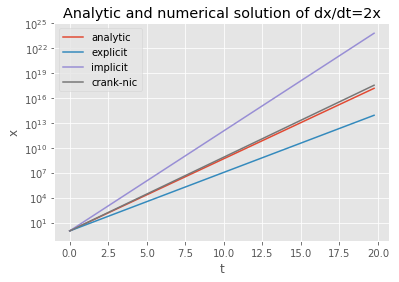

In [21]:
%matplotlib inline
pl.semilogy(tvals, xvals, tvals, yexplicit, tvals, yimplicit, tvals, ycrank)
pl.title('Analytic and numerical solution of dx/dt=2x')
pl.xlabel('t')
pl.ylabel('x')
pl.legend(['analytic', 'explicit', 'implicit','crank-nic'])

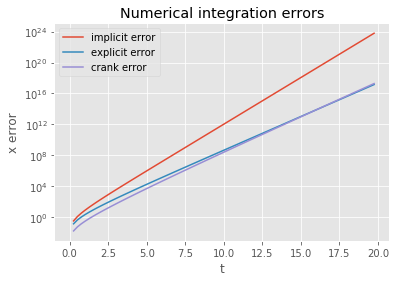

In [22]:
pl.semilogy(tvals,np.abs(yimplicit-xvals), tvals,np.abs(yexplicit-xvals), tvals, np.abs(ycrank-xvals))
pl.title('Numerical integration errors')
pl.xlabel('t')
pl.ylabel('x error')
pl.legend(['implicit error','explicit error', 'crank error'])

# Point Kinetic Equations

Now, the point kinetics equations get solved. The equations are:
$$ \dot{n} = \frac{\rho-\beta}{\Lambda} n + \sum_i \lambda_i C_i $$
$$ \dot{C_i} = \frac{\beta_i}{\Lambda} n - \lambda_i C_i $$

It can easily be shown that if one precursor group is employed the steady concentration of precursors must be:
$$ C = n \frac{\beta}{\lambda {\Lambda}} $$

In [26]:
# now take some example PKE data.
# well, the instructions say "thermal 235U reactor". I happen to
# have some random MSR data laying around... so I'll use that. It's
# highly depleted too, so there will be some nice lowered beta due to
# plutonium presence.
# note: serpent's beta and lambda output gives a one-group with lambda correctly weighted by betas.
betaEff = 6.63263E-03
lambdaEff = 7.69445E-01
gentime = 6.40752E-04

In [24]:
# Analytic solution
n0 = 1000.0
c0 = n0 * betaEff / lambdaEff / gentime


Where the x axis is the time in seconds, and y axis is the neutron population. Sorry, but Mathematica was killing me. I don't want to fuss around more with it to try to force it to give good axis labels. I included the mathematica code below, by the way. It aint pretty.

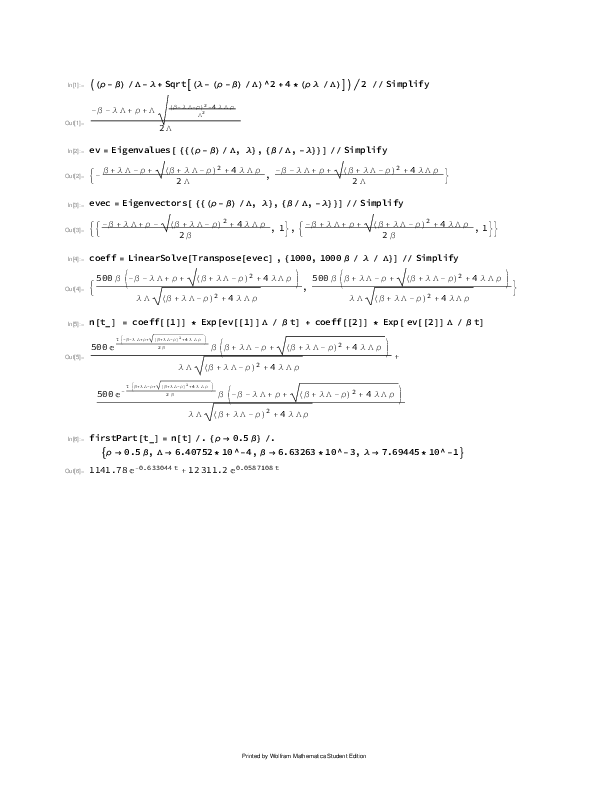

In [6]:
from wand.image import Image as WImage
WImage(filename="/home/gavin/Documents/NE571/maldproj5analytic.pdf[0]")

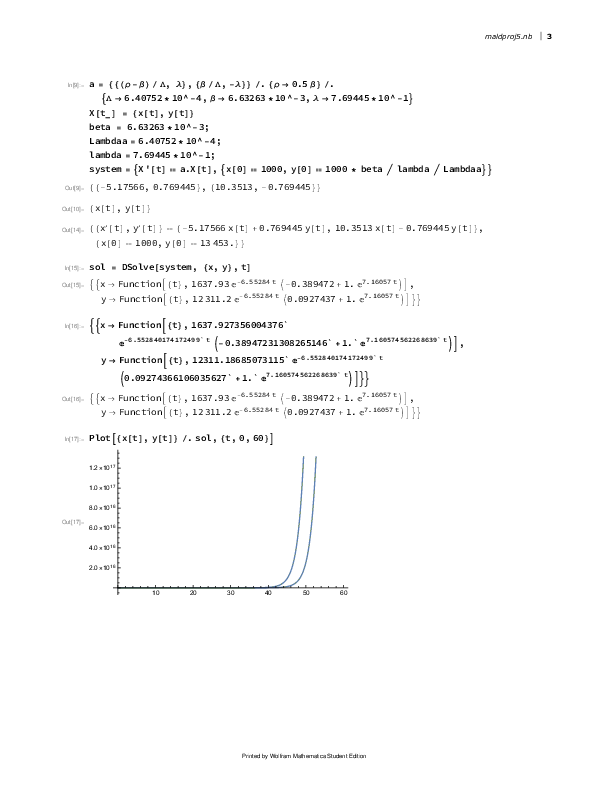

In [8]:
WImage(filename="/home/gavin/Documents/NE571/maldproj5analytic.pdf[2]")

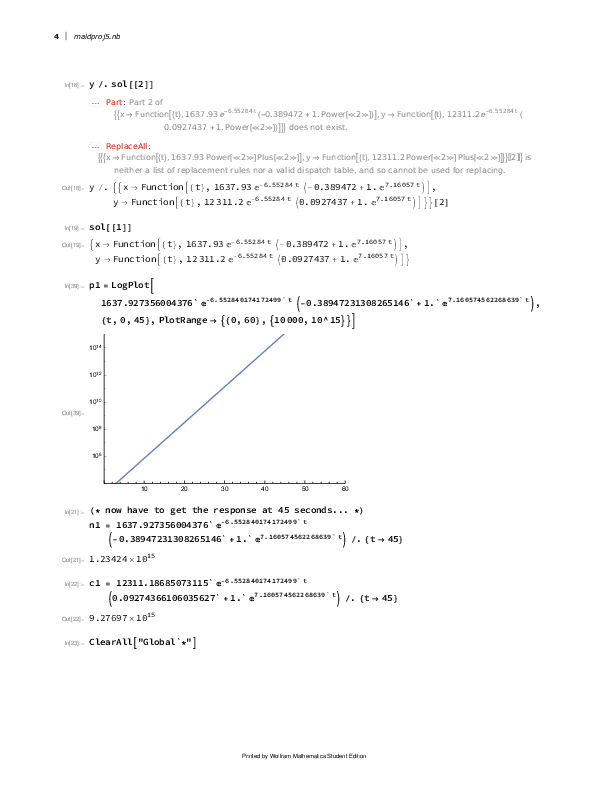

In [9]:
WImage(filename="/home/gavin/Documents/NE571/maldproj5analytic.pdf[3]")

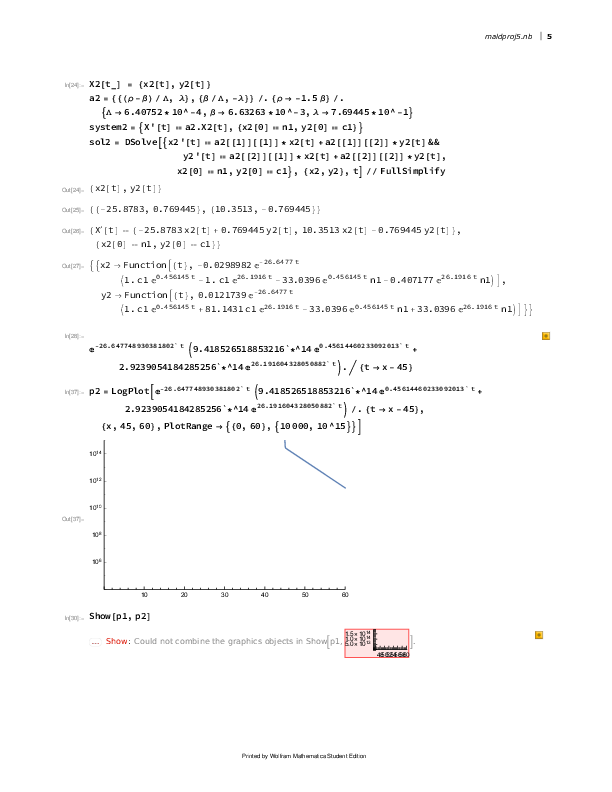

In [10]:
WImage(filename="/home/gavin/Documents/NE571/maldproj5analytic.pdf[4]")

In [16]:
# here's the analytic solution using Mathematica's FortranForm command:
from numpy import e as E
def analyticPKE(t):
    return np.piecewise(t,[t<45.0,t>=45.0],[lambda t: (1637.927356004376*(-0.38947231308265146 + 1.*E**(7.160574562268639*t)))/E**(6.552840174172499*t),
    lambda t: (9.418526518853216e14*E**(0.45614460233092013*(-45 + t)) + 2.9239054184285256e14*E**(26.191604328050882*(-45 + t)))/E**(26.647748930381802*(-45 + t))])

Text(0.5,0,'Time (s)')

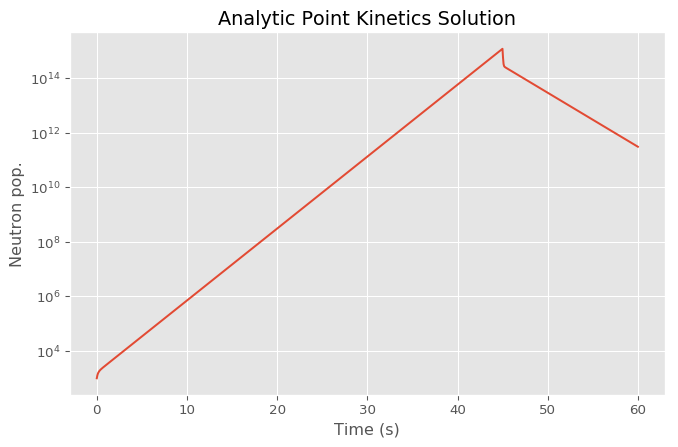

In [35]:
# does it work?
tvals = np.linspace(0,60,1000)
y=analyticPKE(tvals)
fig, ax = pl.subplots(figsize=(8, 5), dpi=96)
ax.semilogy(tvals, y)
ax.set_title("Analytic Point Kinetics Solution")
ax.set_ylabel("Neutron pop.")
ax.set_xlabel("Time (s)")

aw yeah, she's a beaut. you can see a lovely prompt response on both.

In [43]:
# time for the numeric solution.
def rho0(t):
    """ first case reactivity function """
    if t <=45.0:
        return 0.5 * betaEff
    else:
        return -1.5 * betaEff
    
def solvePKEExplicit(tmax, dt, rhofunc, n0, c0):
    """ integrates PKE using explicit stepping"""
    tvals1 = np.arange(0,tmax,dt)
    nvals = np.zeros(len(tvals1))
    cvals = np.zeros(len(tvals1))
    for i in range(len(nvals)):
        if i==0:
            # set IC
            nvals[i] = n0
            cvals[i] = c0
        else:
            nvals[i] = ((rhofunc(dt*i)-betaEff)/gentime*nvals[i-1] + cvals[i-1]*lambdaEff )*dt+nvals[i-1]
            cvals[i] = (betaEff/gentime*nvals[i-1]-lambdaEff*cvals[i-1])*dt+cvals[i-1]
    return tvals1, nvals, cvals

In [44]:
def solvePKEImplicit(tmax,dt,rhofunc,n0,c0):
    """ Integrates PKE via implicit stepping"""
    tvals1 = np.arange(0,tmax,dt)
    nvals = np.zeros(len(tvals1))
    cvals = np.zeros(len(tvals1))

    for i in range(len(nvals)):
        if i==0:
            # set IC
            nvals[i] = n0
            cvals[i] = c0
        else:
            # this is a doozy.
            divisor = (1.0-(rhofunc(i*dt)-betaEff)/gentime*dt)*(1.0+lambdaEff*dt)-lambdaEff*betaEff/gentime*dt**2
            nvals[i] = (1.+lambdaEff*dt)*nvals[i-1]+lambdaEff*dt*cvals[i-1]
            nvals[i] /= divisor
            cvals[i] = betaEff/gentime*dt*nvals[i-1] + (1.- (rhofunc(i*dt)-betaEff)*dt/gentime)*cvals[i-1]
            cvals[i] /= divisor 
    return tvals1, nvals, cvals

In [51]:
%%time
tvImp, nImp, cImp=solvePKEImplicit(60.0, 0.001, rho0, 1000, 1000*betaEff/lambdaEff/gentime)

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 144 ms


In [52]:
%%time
tvExp, nExp, cExp = solvePKEExplicit(60.0, 0.001, rho0, 1000, 1000*betaEff/lambdaEff/gentime)

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 108 ms


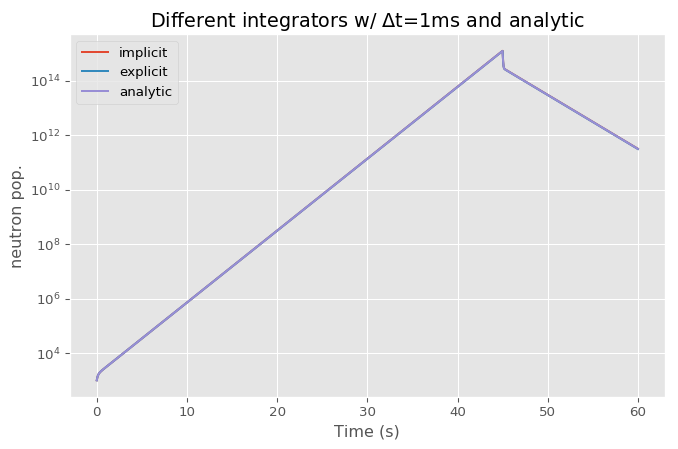

In [56]:
# interesting... the looping in python bottlenecks more than the additional FLOP needed for the implicit soln.
# plot for reasonability:
fix, ax = pl.subplots(figsize=(8,5),dpi=96)
ax.semilogy(tvImp,nImp,tvExp,nExp,tvals,y)
ax.set_title('Different integrators w/ $\Delta$t=1ms and analytic')
ax.set_xlabel('Time (s)')
ax.set_ylabel('neutron pop.')
ax.legend(['implicit','explicit','analytic'])

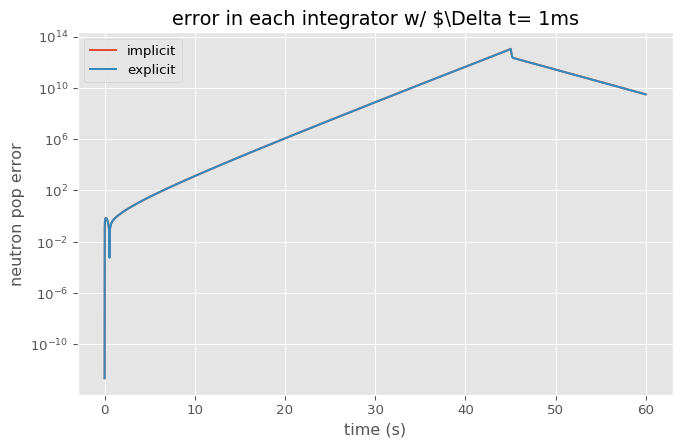

In [61]:
# error plot
erp, ax2 = pl.subplots(figsize=(8,5),dpi=96)
ax2.semilogy(tvImp,np.abs(nImp-analyticPKE(tvImp)),tvExp,np.abs(nExp-analyticPKE(tvExp)))
ax2.set_title('error in each integrator w/ $\Delta t= 1ms')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('neutron pop error')
ax2.legend(['implicit','explicit'])

In [62]:
#coarser integration:
tvImp, nImp, cImp=solvePKEImplicit(60.0, 1., rho0, 1000, 1000*betaEff/lambdaEff/gentime)
tvExp, nExp, cExp = solvePKEExplicit(60.0, 1., rho0, 1000, 1000*betaEff/lambdaEff/gentime)

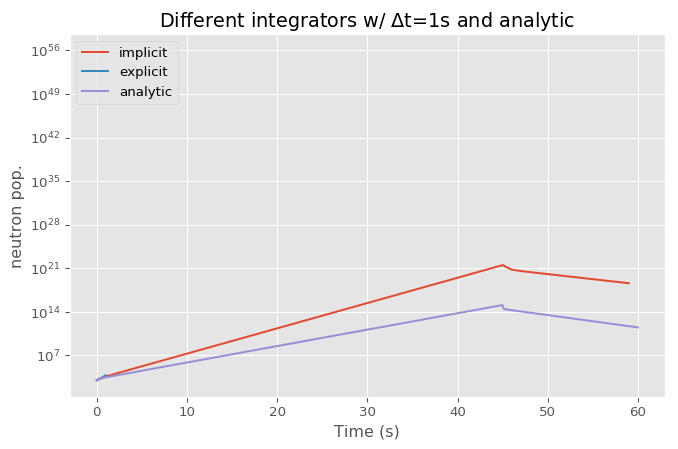

In [63]:
fix, ax = pl.subplots(figsize=(8,5),dpi=96)
ax.semilogy(tvImp,nImp,tvExp,nExp,tvals,y)
ax.set_title('Different integrators w/ $\Delta$t=1s and analytic')
ax.set_xlabel('Time (s)')
ax.set_ylabel('neutron pop.')
ax.legend(['implicit','explicit','analytic'])

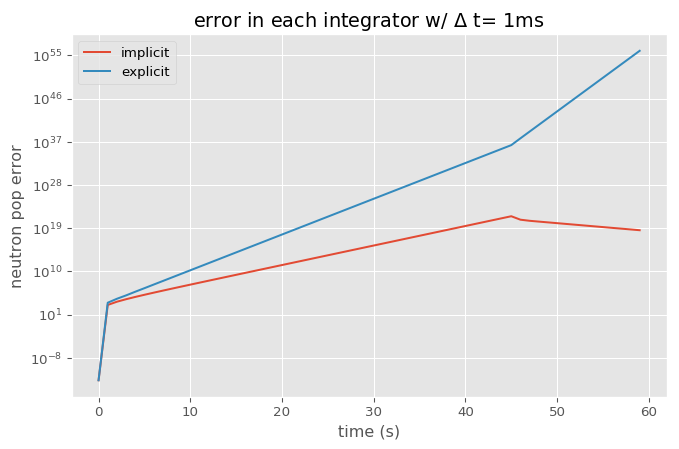

In [65]:
# error plot
erp, ax2 = pl.subplots(figsize=(8,5),dpi=96)
ax2.semilogy(tvImp,np.abs(nImp-analyticPKE(tvImp)),tvExp,np.abs(nExp-analyticPKE(tvExp)))
ax2.set_title('error in each integrator w/ $\Delta$ t= 1ms')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('neutron pop error')
ax2.legend(['implicit','explicit'])

Much like post malone, we can see that the explicit integrator falls apart with sufficiently large 
timesteps. Seems that $\Delta t$=1ms safely integrates. The instability in the explicit solution can
be attributed to the large difference in the eigenvalues of the xdot = A x matrix.

In [66]:
# a big freaking reactivity insertion. a buck fiddy is what blows stuff up.

In [67]:
def rho1(t):
    return 1.5*betaEff

In [68]:
tvImp, nImp, cImp=solvePKEImplicit(60.0, 0.001, rho1, 1000, 1000*betaEff/lambdaEff/gentime)

Text(0,0.5,'neutron pop.')

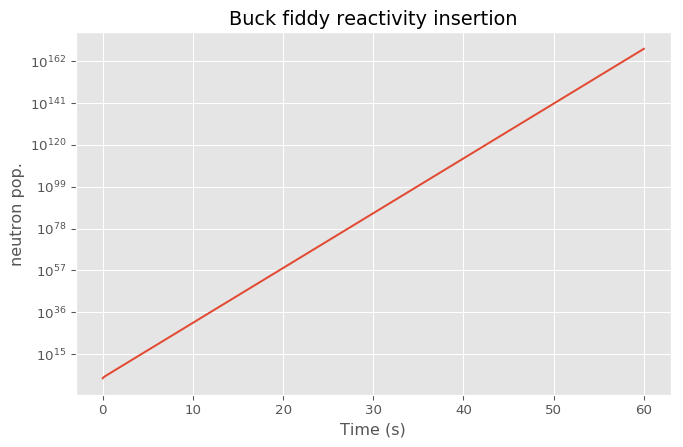

In [69]:
fix, ax = pl.subplots(figsize=(8,5),dpi=96)
ax.semilogy(tvImp,nImp)
ax.set_title('Buck fiddy reactivity insertion')
ax.set_xlabel('Time (s)')
ax.set_ylabel('neutron pop.')

In [70]:
# the result: google "SL1 reactor"

In [71]:
# now finally, run with zero precursor initial concentration.
def rho2(t):
    return 0.0
tvImp, nImp, cImp=solvePKEImplicit(60.0, 0.001, rho2, 1000, 0.0)

Text(0,0.5,'neutron pop.')

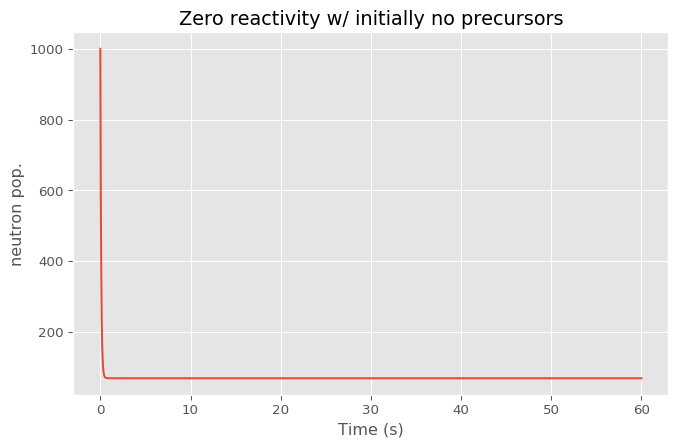

In [73]:
fix, ax = pl.subplots(figsize=(8,5),dpi=96)
ax.plot(tvImp,nImp)
ax.set_title('Zero reactivity w/ initially no precursors')
ax.set_xlabel('Time (s)')
ax.set_ylabel('neutron pop.')

In [76]:
# the neutron population falls to zero because missing precursors imply the reactor is in a subcritical state.
# if there were an external source term like in real life, the reactor would come back to criticality.
# so, let's insert ten cents of reactivity alongside starting w/ no precs.

Text(0,0.5,'neutron pop.')

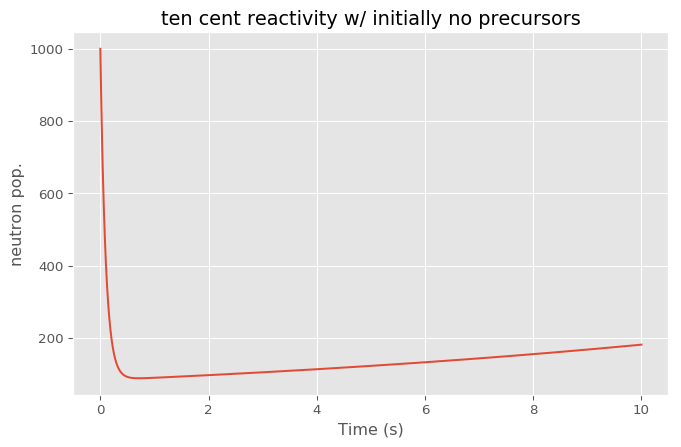

In [82]:
def rho3(t):
    return 0.1*betaEff
tvImp, nImp, cImp=solvePKEImplicit(10.0, 0.001, rho3, 1000, 0.0)
fix, ax = pl.subplots(figsize=(8,5),dpi=96)
ax.plot(tvImp,nImp)
ax.set_title('ten cent reactivity w/ initially no precursors')
ax.set_xlabel('Time (s)')
ax.set_ylabel('neutron pop.')

In [81]:
# it seems that adding ten cents allows the neutron population to just barely not hit zero, thus
# allowing the reactor to start to come back to power. Let's check out letting it run longer:

Text(0,0.5,'neutron pop.')

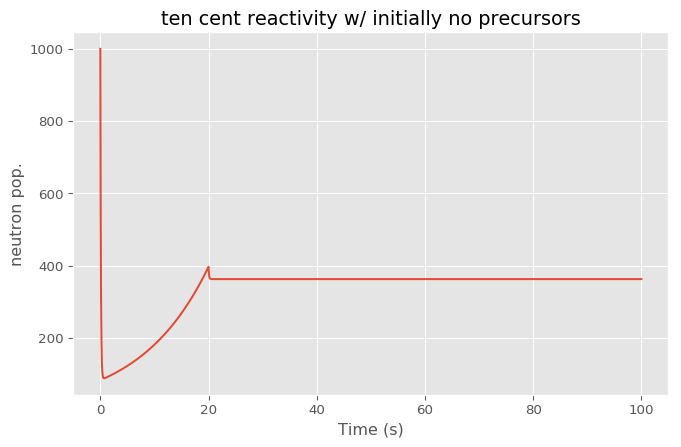

In [84]:
def rho3(t):
    if t<20.0:
        return 0.1*betaEff
    else:
        return 0.0
tvImp, nImp, cImp=solvePKEImplicit(100.0, 0.001, rho3, 1000, 0.0)
fix, ax = pl.subplots(figsize=(8,5),dpi=96)
ax.plot(tvImp,nImp)
ax.set_title('ten cent reactivity w/ initially no precursors')
ax.set_xlabel('Time (s)')
ax.set_ylabel('neutron pop.')

In [85]:
# fun :D